
# This is the draft notebook 

In [2]:
# import modules

import numpy as np
import pandas as pd # import library for data analysis

from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns # for nicer plots (not essential)
sns.set_theme('talk', style = 'white')

import openpyxl
print(openpyxl.__version__)

/Users/astateo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


ModuleNotFoundError: No module named 'get_regression_coefs_general'

In [1]:
# 2.1) Load dataset
data = pd.read_excel('pwt100.xlsx', sheet_name = 'Data', header = 0)

NameError: name 'pd' is not defined

In [ ]:
# 2.2) Clean data

# Subset relevant columns and compute per capita real GDP
data = data.loc[:, ("country", "year", "rgdpna", "pop")]
data["rgdpna_pc"] = data["rgdpna"] / data["pop"]

# select Indonesia
data_indonesia = data.loc[data["country"] == "Indonesia", ("year", "rgdpna", "rgdpna_pc")]
# Reset the index
data_indonesia = data_indonesia.reset_index(drop = True)

# Subset the RGDP and RGDP per capita series
ymax = 2019
ymin = 1960
# We use logical indexing to subset the data to rows of years ymin <= year <= ymax
Y_gdp = data_indonesia.loc[np.logical_and(data_indonesia["year"] <= ymax, data_indonesia["year"] >= ymin), "rgdpna"]
Y_pc = data_indonesia.loc[np.logical_and(data_indonesia["year"] <= ymax, data_indonesia["year"] >= ymin), "rgdpna_pc"]
y_gdp = np.log(Y_gdp)
y_pc = np.log(Y_pc)
data_indonesia = data_indonesia[data_indonesia["year"] >= ymin] 

# Compute separate sample sizes for the subsample used for estimation and the whole sample.
T_gdp = len(Y_gdp) # sample size used for regression
T_pc = len(Y_pc)
T_all = data_indonesia["year"].max() - (ymin - 1)

# Check values
print(T_gdp)
print(T_pc)
print(T_all)

60
60
60


In [ ]:
# 3.1) Additive Linear Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is RGDP and RGDP per capita in *levels*

def additive_linear_model(Y, T_input):
    T = len(Y)
    x1 = np.empty(T) # initialise an empty vector for the first regressor
    x2 = np.empty(T) # initialise an empty vector for the second regressor

    for t in range(T):
        x1[t] = 1.
        x2[t] = t + 1 # recall that Python starts indexing at 0
        
    a_add_lin, b_add_lin = get_regression_coefs(Y, x1, x2)
    
    # Initialise predicted values yhat
    Yhat_add_lin = np.empty(T_input)
    
    # Create loop to compute trend for all years
    for t in range(T_input):
        Yhat_add_lin[t] = a_add_lin + b_add_lin * (t + 1) # recall that Python indexing starts at 0
        
    # Let us convert into log-units
    yhat_add_lin = np.log(Yhat_add_lin)

    return Yhat_add_lin, yhat_add_lin

# Apply the function to both RGDP and RGDP per capita
Yhat_add_lin_gdp, yhat_add_lin_gdp = additive_linear_model(Y_gdp, T_all)
Yhat_add_lin_pc, yhat_add_lin_pc = additive_linear_model(Y_pc, T_all)

-375848.256770834
45166.34269979508
-93.83172831619453
159.3352245804634


/var/folders/4y/2ptmtdss0498hlfm7wwgdysr0000gn/T/ipykernel_91343/2125963905.py:26: RuntimeWarning: invalid value encountered in log
  yhat_add_lin = np.log(Yhat_add_lin)


In [ ]:
# 3.2) Additive Quadratic Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T, third regressor x3 is the vector 1, 4, ..., T^2
# The dependent variable is per capita GDP in *levels*

def additive_quadratic_model(Y, T_input):
    T = len(Y)
    x1 = np.empty(T) 
    x2 = np.empty(T) 
    x3 = np.empty(T)

    for t in range(T):
        x1[t] = 1
        x2[t] = t + 1
        x3[t] = (t + 1) ** 2

    a_add_quad, b1_add_quad, b2_add_quad = get_regression_coefs(Y, x1, x2, x3)
    
    # Initialise predicted values yhat
    Yhat_add_quad = np.empty(T_input)
    
    # Create loop to compute trend for all years
    for t in range(T_input):
        Yhat_add_quad[t] = a_add_quad + b1_add_quad * (t + 1) + b2_add_quad * (t + 1) ** 2
        
    # Take the natural logarithm of the shifted fitted values
    yhat_add_quad = np.log(Yhat_add_quad)
    
    return Yhat_add_quad, yhat_add_quad

# Apply the function to both RGDP and RGDP per capita
Yhat_add_quad_gdp, yhat_add_quad_gdp = additive_quadratic_model(Y_gdp, T_all)
Yhat_add_quad_pc, yhat_add_quad_pc = additive_quadratic_model(Y_pc, T_all)

232745.87230740878
-13729.863340034428
965.511574423432
1500.3252810284735
5.061965611626861
2.5290698191612484


In [ ]:
# 3.3) Exponential Linear Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is per capita GDP in *ln*

def exponential_linear_model(Y, T_input):
    T = len(Y)
    x1 = np.empty(T) 
    x2 = np.empty(T) 

    for t in range(T):
        x1[t] = 1
        x2[t] = t + 1
        
    y_exp_lin = np.log(Y)
    
    a_exp_lin, b_exp_lin = get_regression_coefs(y_exp_lin, x1, x2)
    
    # Initialise predicted values yhat
    yhat_exp_lin = np.empty(T_input)
    
    # Create loop to compute trend for all years
    for t in range(T_input):
        yhat_exp_lin[t] = a_exp_lin + b_exp_lin * (t + 1)

    return yhat_exp_lin

# Apply the function to both RGDP and RGDP per capita
yhat_exp_lin_gdp = exponential_linear_model(Y_gdp, T_all)
yhat_exp_lin_pc = exponential_linear_model(Y_pc, T_all)

In [ ]:
# 3.4) Exponential Quadratic Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T, third regressor x3 is the vector 1, 4, ..., T^2
# The dependent variable is per capita GDP in *ln*

def exponential_quadratic_model(Y, T_input):
    T = len(Y)
    x1 = np.empty(T) 
    x2 = np.empty(T) 
    x3 = np.empty(T)

    for t in range(T):
        x1[t] = 1
        x2[t] = t + 1
        x3[t] = (t + 1) ** 2
        
    y_exp_quad = np.log(Y)
    
    a_exp_quad, b1_exp_quad, b2_exp_quad = get_regression_coefs(y_exp_quad, x1, x2, x3)
    
    # Initialise predicted values yhat
    yhat_exp_quad = np.empty(T_input)
    
    # Create loop to compute trend for all years
    for t in range(T_input):
        yhat_exp_quad[t] = a_exp_quad + b1_exp_quad * (t + 1) + b2_exp_quad * (t + 1) ** 2
        
    return yhat_exp_quad 

# Apply the function to both RGDP and RGDP per capita
yhat_exp_quad_gdp = exponential_quadratic_model(Y_gdp, T_all)
yhat_exp_quad_pc = exponential_quadratic_model(Y_pc, T_all)   

Text(0.5, 1.0, 'Exponential Model: Real GDP per capita Time Trend')

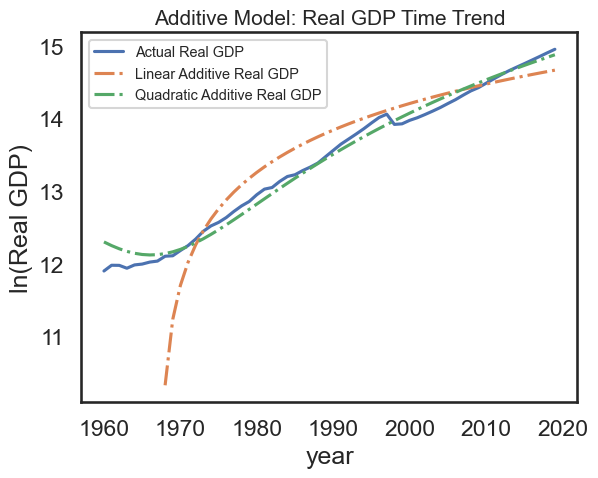

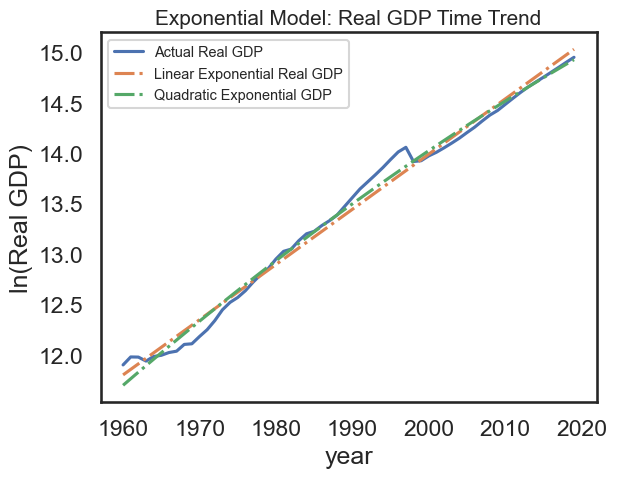

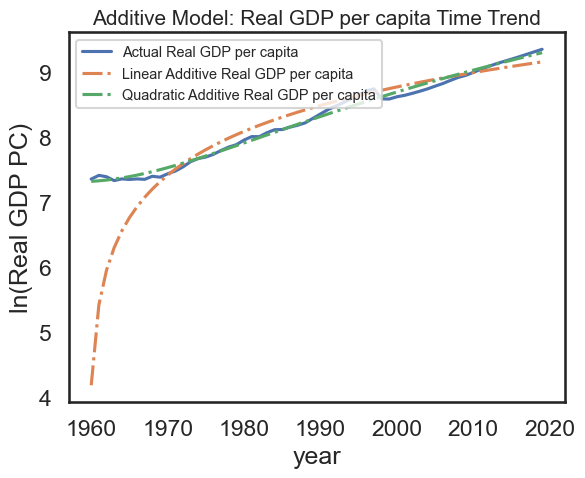

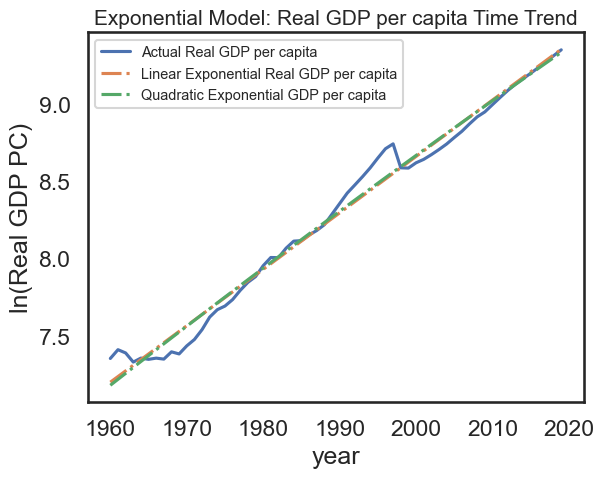

In [ ]:
lw = 4

#Plot Additive Graph for RGDP 
plt.figure()
plt.plot(data_indonesia['year'],np.log(data_indonesia['rgdpna']), label="Actual Real GDP")
plt.plot(data_indonesia['year'],yhat_add_lin_gdp, label="Linear Additive Real GDP", linestyle = "dashdot")
plt.plot(data_indonesia['year'],yhat_add_quad_gdp, label="Quadratic Additive Real GDP", linestyle = "dashdot")

#labels
plt.xlabel("year")
plt.ylabel("ln(Real GDP)")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Additive Model: Real GDP Time Trend", fontsize = 15)

#Plot Exponential Graph for RGDP PC
plt.figure()
plt.plot(data_indonesia['year'],np.log(data_indonesia['rgdpna']), label="Actual Real GDP")
plt.plot(data_indonesia['year'],yhat_exp_lin_gdp, label="Linear Exponential Real GDP", linestyle = "dashdot")
plt.plot(data_indonesia['year'],yhat_exp_quad_gdp, label="Quadratic Exponential GDP", linestyle = "dashdot")

#labels
plt.xlabel("year")
plt.ylabel("ln(Real GDP)")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Exponential Model: Real GDP Time Trend", fontsize = 15)


#Plot Additive Graph for RGDP PC
plt.figure()
plt.plot(data_indonesia['year'],np.log(data_indonesia['rgdpna_pc']), label="Actual Real GDP per capita")
plt.plot(data_indonesia['year'],yhat_add_lin_pc, label="Linear Additive Real GDP per capita", linestyle = "dashdot")
plt.plot(data_indonesia['year'],yhat_add_quad_pc, label="Quadratic Additive Real GDP per capita", linestyle = "dashdot")

#labels
plt.xlabel("year")
plt.ylabel("ln(Real GDP PC)")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Additive Model: Real GDP per capita Time Trend", fontsize = 15)

#Plot Exponential Graph for RGDP PC
plt.figure()
plt.plot(data_indonesia['year'],np.log(data_indonesia['rgdpna_pc']), label="Actual Real GDP per capita")
plt.plot(data_indonesia['year'],yhat_exp_lin_pc, label="Linear Exponential Real GDP per capita", linestyle = "dashdot")
plt.plot(data_indonesia['year'],yhat_exp_quad_pc, label="Quadratic Exponential GDP per capita", linestyle = "dashdot")

#labels
plt.xlabel("year")
plt.ylabel("ln(Real GDP PC)")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Exponential Model: Real GDP per capita Time Trend", fontsize = 15)

39
21
39
21
39
21


Text(0.5, 1.0, 'Revised Exponential Quadratic Model: Real GDP per capita Time Trend')

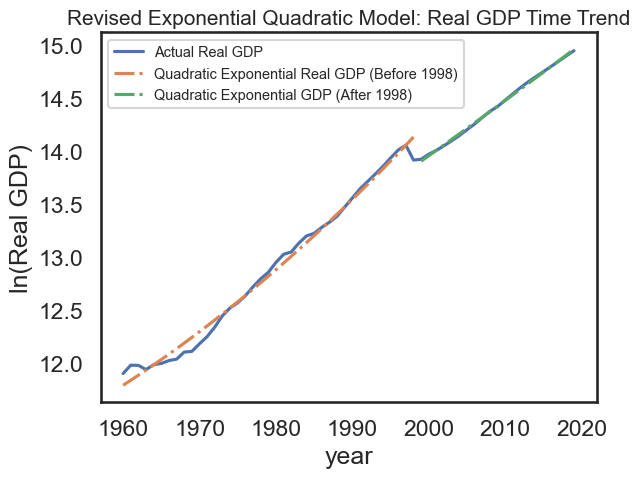

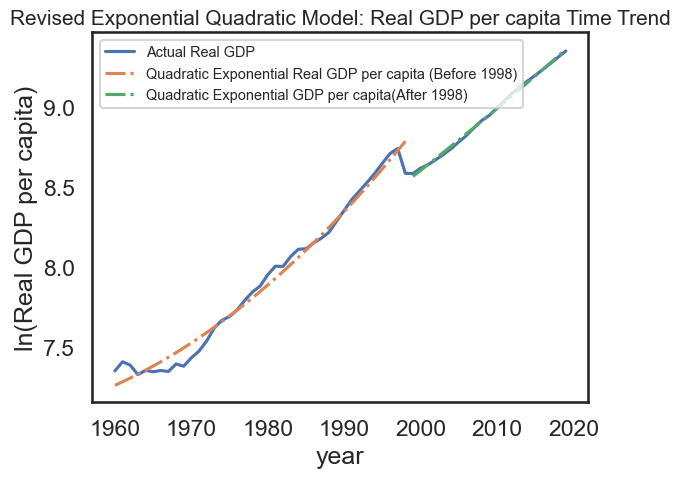

In [ ]:
# Split data set into 2 subperiods - before and after 1998 
data_indonesia_before_1998 = data_indonesia[data_indonesia["year"] <= 1998]
data_indonesia_after_1998 = data_indonesia[data_indonesia["year"] > 1998]

# Subset the RGDP and RGDP per capita series
Y_gdp_before_1998 = data_indonesia_before_1998["rgdpna"]
Y_gdp_after_1998 = data_indonesia_after_1998["rgdpna"]
Y_pc_before_1998 = data_indonesia_before_1998["rgdpna_pc"]
Y_pc_after_1998 = data_indonesia_after_1998["rgdpna_pc"]

# Compute separate sample sizes for the subsample used for estimation and the whole sample.
T_gdp_before_1998 = len(Y_gdp_before_1998) 
T_gdp_after_1998 = len(Y_gdp_after_1998) 
T_pc_before_1998 = len(Y_pc_before_1998) 
T_pc_after_1998 = len(Y_pc_after_1998) 
T_before_1998 = 1998 - ymin + 1
T_after_1998 = ymax - 1998

# Check values
print(T_gdp_before_1998)
print(T_gdp_after_1998)
print(T_pc_before_1998)
print(T_pc_after_1998)
print(T_before_1998)
print(T_after_1998)

# Derive fitted values for the 2 subperiods using exponential quadratic model 
yhat_exp_quad_gdp_before_1998 = exponential_quadratic_model(Y_gdp_before_1998, T_before_1998)
yhat_exp_quad_gdp_after_1998 = exponential_quadratic_model(Y_gdp_after_1998, T_after_1998)
yhat_exp_quad_pc_before_1998 = exponential_quadratic_model(Y_pc_before_1998, T_before_1998)
yhat_exp_quad_pc_after_1998 = exponential_quadratic_model(Y_pc_after_1998, T_after_1998)

#Plot Exponential Quadratic Graph for RGDP
plt.figure()
plt.plot(data_indonesia['year'],np.log(data_indonesia['rgdpna']), label="Actual Real GDP")
plt.plot(data_indonesia_before_1998['year'],yhat_exp_quad_gdp_before_1998, label="Quadratic Exponential Real GDP (Before 1998)", linestyle = "dashdot")
plt.plot(data_indonesia_after_1998['year'],yhat_exp_quad_gdp_after_1998, label="Quadratic Exponential GDP (After 1998)", linestyle = "dashdot")

#labels
plt.xlabel("year")
plt.ylabel("ln(Real GDP)")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Revised Exponential Quadratic Model: Real GDP Time Trend", fontsize = 15)


#Plot Exponential Quadratic Graph for RGDP PC
plt.figure()
plt.plot(data_indonesia['year'],np.log(data_indonesia['rgdpna_pc']), label="Actual Real GDP")
plt.plot(data_indonesia_before_1998['year'],yhat_exp_quad_pc_before_1998, label="Quadratic Exponential Real GDP per capita (Before 1998)", linestyle = "dashdot")
plt.plot(data_indonesia_after_1998['year'],yhat_exp_quad_pc_after_1998, label="Quadratic Exponential GDP per capita(After 1998)", linestyle = "dashdot")

#labels
plt.xlabel("year")
plt.ylabel("ln(Real GDP per capita)")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Revised Exponential Quadratic Model: Real GDP per capita Time Trend", fontsize = 15)


,year,rgdpna,emp,rnna,hc,TFP_alpha_0.25,TFP_alpha_0.3,TFP_alpha_0.35
0,1960,1.475389e+05,28.498953,7.623768e+05,1.158581,2584.620672,2210.380296,1845.382708
1,1961,1.596486e+05,29.060551,7.653232e+05,1.176857,2768.498671,2384.611743,2007.325066
2,1962,1.594061e+05,29.569380,7.644622e+05,1.195421,2674.185813,2303.290030,1938.785826
3,1963,1.532446e+05,30.088734,7.563245e+05,1.214278,2463.517674,2116.045162,1775.561034
4,1964,1.603702e+05,30.618654,7.516056e+05,1.233432,2537.466753,2190.323887,1848.360916
5,1965,1.622570e+05,31.159178,7.476065e+05,1.252888,2497.746395,2159.537477,1825.794865
6,1966,1.667850e+05,31.710342,7.471328e+05,1.272652,2507.069386,2173.418853,1843.225704
7,1967,1.690491e+05,32.272175,7.406710e+05,1.292727,2476.321898,2151.300857,1828.918223
8,1968,1.807467e+05,32.844719,7.435955e+05,1.313118,2615.444282,2285.829922,1956.780513
9,1969,1.818787e+05,33.427994,7.511329e+05,1.333832,2542.487892,2221.255068,1900.698727


Text(0.5, 1.0, 'Time Series of TFP')

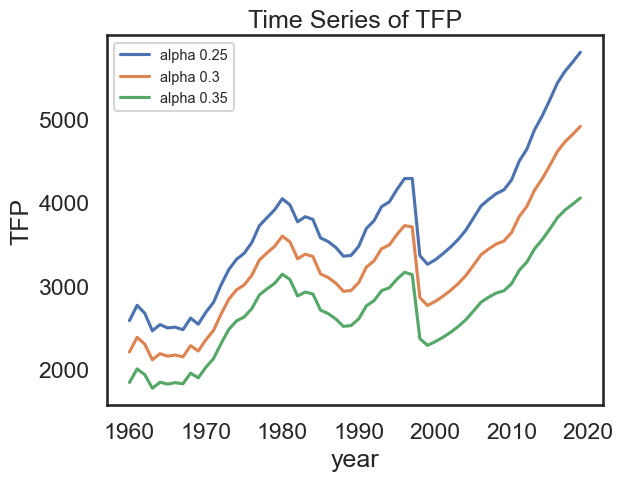

In [ ]:
# Part B, calculating TFP 
# Load dataset
data = pd.read_excel('pwt100.xlsx', sheet_name='Data', header=0)

# Extract relevant variables in production function and select Indonesia
data_indonesia_b = data.loc[data["country"] == "Indonesia", ["year", "rgdpna", "emp", "rnna", "hc"]]

# Drop rows with missing values in specified columns
data_indonesia_b.dropna(subset=["rgdpna", "emp", "rnna", "hc"], inplace=True)

# Define a list of alpha values for robustness check
alpha_values = [0.25, 0.3, 0.35]

# Calculate TFP for each alpha and store the results in a dictionary
tfp_results = {}

for alpha in alpha_values:
    tfp = (1/(data_indonesia_b["emp"]*data_indonesia_b["hc"]))*(data_indonesia_b["rgdpna"]/(data_indonesia_b["rnna"])**alpha)**(1/(1-alpha))
    tfp_results[f"TFP_alpha_{alpha}"] = tfp

# Convert the results dictionary to a DataFrame for better visualization
tfp_df = pd.DataFrame(tfp_results)

# Add the year column for reference
tfp_df["year"] = data_indonesia_b["year"]

# Merge the TFP DataFrame with the original Indonesia DataFrame
data_indonesia_b = data_indonesia_b.merge(tfp_df, on="year")

# Display the updated DataFrame
display(data_indonesia_b)

#Plot Time Series
plt.figure()
plt.plot(data_indonesia_b['year'],data_indonesia_b["TFP_alpha_0.25"], label="alpha 0.25")
plt.plot(data_indonesia_b['year'],data_indonesia_b["TFP_alpha_0.3"], label="alpha 0.3")
plt.plot(data_indonesia_b['year'],data_indonesia_b["TFP_alpha_0.35"], label="alpha 0.35")

#labels
plt.xlabel("year")
plt.ylabel("TFP")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Time Series of TFP")

,year,rgdpna,emp,rnna,hc,TFP_alpha_0.25,TFP_alpha_0.3,TFP_alpha_0.35
0,1960,1.475389e+05,28.498953,7.623768e+05,1.158581,2584.620672,2210.380296,1845.382708
1,1961,1.596486e+05,29.060551,7.653232e+05,1.176857,2768.498671,2384.611743,2007.325066
2,1962,1.594061e+05,29.569380,7.644622e+05,1.195421,2674.185813,2303.290030,1938.785826
3,1963,1.532446e+05,30.088734,7.563245e+05,1.214278,2463.517674,2116.045162,1775.561034
4,1964,1.603702e+05,30.618654,7.516056e+05,1.233432,2537.466753,2190.323887,1848.360916
5,1965,1.622570e+05,31.159178,7.476065e+05,1.252888,2497.746395,2159.537477,1825.794865
6,1966,1.667850e+05,31.710342,7.471328e+05,1.272652,2507.069386,2173.418853,1843.225704
7,1967,1.690491e+05,32.272175,7.406710e+05,1.292727,2476.321898,2151.300857,1828.918223
8,1968,1.807467e+05,32.844719,7.435955e+05,1.313118,2615.444282,2285.829922,1956.780513
9,1969,1.818787e+05,33.427994,7.511329e+05,1.333832,2542.487892,2221.255068,1900.698727


,Y growth,K contribution,L contribution,h contribution,A contribution,K contribution proportion,h contribution proportion,L contribution proportion,A contribution proportion
year,,,,,,,,,
1960-1970,0.281279,0.010385,0.440837,0.389497,0.159280,0.002921,0.109557,0.123998,0.044802
1970-1980,0.767951,0.245765,0.265194,0.103752,0.385288,0.188735,0.079677,0.203656,0.295883
1980-1990,0.608867,0.383940,0.554069,0.255054,-0.193064,0.233769,0.155294,0.337355,-0.117550
1990-2000,0.413341,0.521737,0.367473,0.241396,-0.130606,0.215656,0.099779,0.151892,-0.053985
2000-2010,0.510038,0.280599,0.228779,0.137946,0.352676,0.143116,0.070358,0.116686,0.179878
2010-2019,0.466961,0.344177,0.289222,-0.081971,0.448572,0.160717,-0.038277,0.135055,0.209465


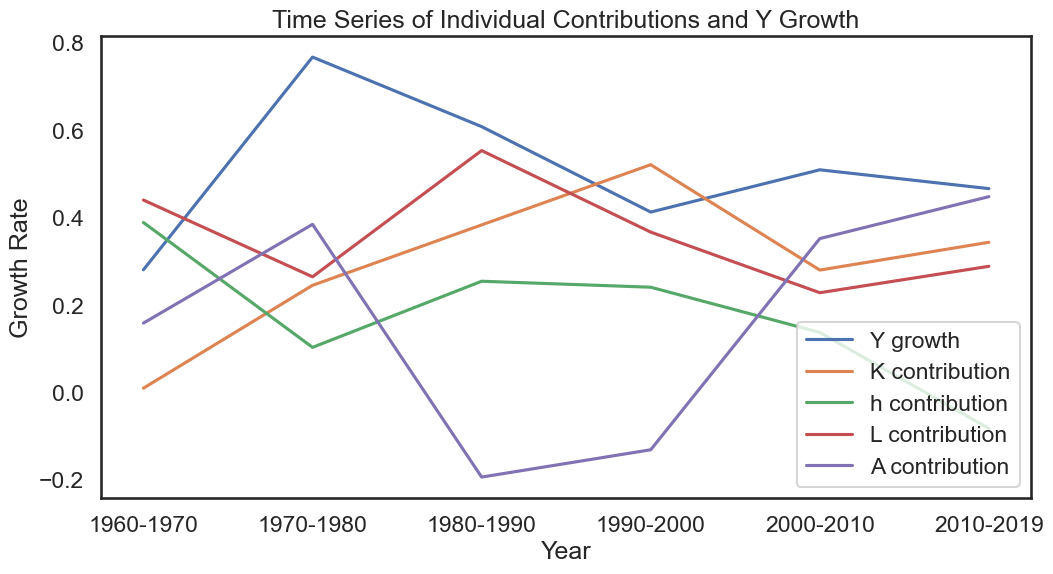

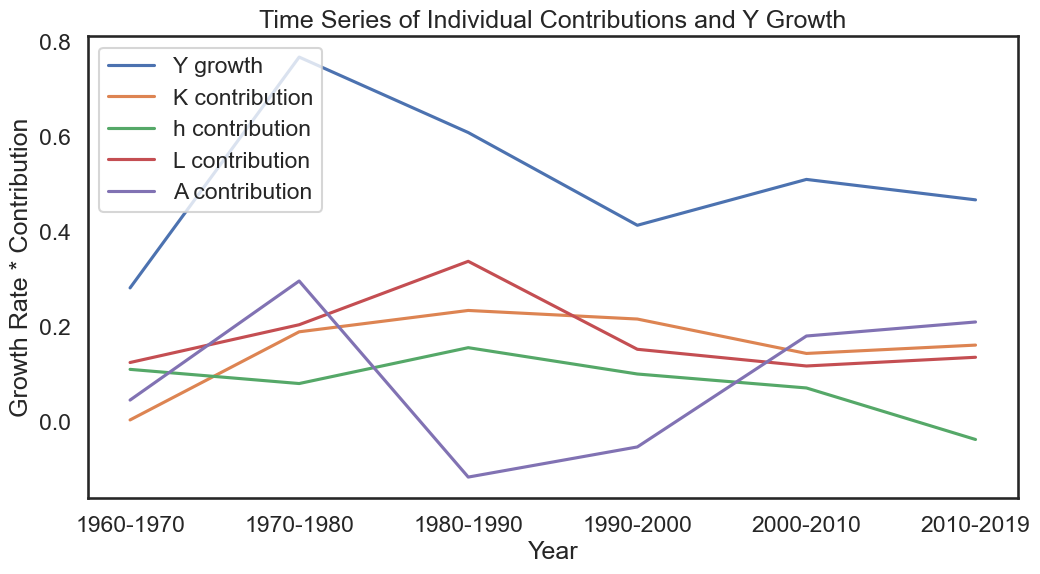

In [ ]:
# Part C, Growth Accounting
# Ensure the year column is of integer type
data_indonesia_b["year"] = data_indonesia_b["year"].astype(int)

# Display the updated DataFrame
display(data_indonesia_b)

# Initialise dataframe with NaNs
avg_growth_rates = pd.DataFrame(
    data = np.full((6, 5), np.nan),
    columns = ['Y growth', 'K growth', 'L growth','h growth', 'A growth']
)
avg_growth_rates['year'] = ["1960-1970", "1970-1980", "1980-1990", "1990-2000", "2000-2010", "2010-2019"]
avg_growth_rates = avg_growth_rates.set_index('year')

# Set alpha = 0.3 
alpha = 0.3 

# Fill with average growth rates from data_indonesia_b
cols = ['rgdpna', 'rnna', 'emp', 'hc', 'TFP_alpha_0.3']

# Ensure the years exist in the DataFrame
years = [1960, 1970, 1980, 1990, 2000, 2010, 2019]
for start, end in zip(years[:-1], years[1:]):
    if start in data_indonesia_b["year"].values and end in data_indonesia_b["year"].values:
        avg_growth_rates.loc[f"{start}-{end}"] = np.log(data_indonesia_b.loc[data_indonesia_b["year"] == end, cols].values / data_indonesia_b.loc[data_indonesia_b["year"] == start, cols].values).flatten()

# Compute contribution rates
df_contribs_long = avg_growth_rates.copy()
df_contribs_long['K contribution'] = alpha * (df_contribs_long['K growth'] / df_contribs_long['Y growth'])
df_contribs_long['h contribution'] = (1 - alpha) * (df_contribs_long['h growth'] / df_contribs_long['Y growth'])
df_contribs_long['L contribution'] = (1 - alpha) * (df_contribs_long['L growth'] / df_contribs_long['Y growth'])
df_contribs_long['A contribution'] = (1 - alpha) * (df_contribs_long['A growth'] / df_contribs_long['Y growth'])

# Only keep selected columns
df_contribs_long = df_contribs_long[['Y growth', 'K contribution', 'L contribution', 'h contribution', 'A contribution']]

# Calculate the proportions of each contribution to Y growth
df_contribs_long['K contribution proportion'] = df_contribs_long['K contribution'] * df_contribs_long['Y growth']
df_contribs_long['h contribution proportion'] = df_contribs_long['h contribution'] * df_contribs_long['Y growth']
df_contribs_long['L contribution proportion'] = df_contribs_long['L contribution'] * df_contribs_long['Y growth']
df_contribs_long['A contribution proportion'] = df_contribs_long['A contribution'] * df_contribs_long['Y growth']

# Display the updated DataFrame
display(df_contribs_long)

# Plotting the time series
plt.figure(figsize=(12, 6))

# Plot Y growth
plt.plot(df_contribs_long.index, df_contribs_long['Y growth'], label='Y growth')

# Plot K contribution
plt.plot(df_contribs_long.index, df_contribs_long['K contribution'], label='K contribution')

# Plot h contribution
plt.plot(df_contribs_long.index, df_contribs_long['h contribution'], label='h contribution')

# Plot L contribution
plt.plot(df_contribs_long.index, df_contribs_long['L contribution'], label='L contribution')

# Plot A contribution
plt.plot(df_contribs_long.index, df_contribs_long['A contribution'], label='A contribution')

# Adding titles and labels
plt.title('Time Series of Individual Contributions and Y Growth')
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.legend()

# Display the plot
plt.show()



# Plotting the time series
plt.figure(figsize=(12, 6))

# Plot Y growth
plt.plot(df_contribs_long.index, df_contribs_long['Y growth'], label='Y growth')

# Plot K contribution
plt.plot(df_contribs_long.index, df_contribs_long['K contribution proportion'], label='K contribution')

# Plot h contribution
plt.plot(df_contribs_long.index, df_contribs_long['h contribution proportion'], label='h contribution')

# Plot L contribution
plt.plot(df_contribs_long.index, df_contribs_long['L contribution proportion'], label='L contribution')

# Plot A contribution
plt.plot(df_contribs_long.index, df_contribs_long['A contribution proportion'], label='A contribution')

# Adding titles and labels
plt.title('Time Series of Individual Contributions and Y Growth')
plt.xlabel('Year')
plt.ylabel('Growth Rate * Contribution')
plt.legend()

# Display the plot
plt.show()

    year  labour_productivity
0   1960          5176.994487
1   1961          5493.653960
2   1962          5390.918783
3   1963          5093.090400
4   1964          5237.664368
5   1965          5207.356698
6   1966          5259.641941
7   1967          5238.231084
8   1968          5503.067434
9   1969          5440.910861
10  1970          5745.191633
11  1971          6000.255627
12  1972          6424.987620
13  1973          6763.413031
14  1974          7074.034592
15  1975          7355.429809
16  1976          7713.181824
17  1977          8220.724631
18  1978          8537.991898
19  1979          8881.737335
20  1980          9256.968549
21  1981          9350.691429
22  1982          9313.404347
23  1983          9706.602297
24  1984          9868.261792
25  1985          9649.788154
26  1986          9762.890424
27  1987          9824.805528
28  1988          9771.643059
29  1989          9973.023888
30  1990         10509.804792
31  1991         11341.885400
32  1992  

Text(0.5, 1.0, 'Time Series of TFP and Labour Productivity')

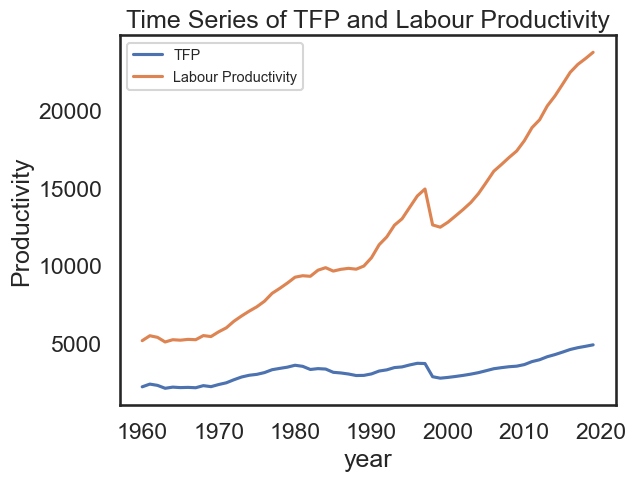

In [ ]:
# Part D, Labour Productivity 
# Calculate labor productivity (GDP per worker)
data_indonesia_b["labour_productivity"] = data_indonesia_b["rgdpna"] / data_indonesia_b["emp"]

# Display the updated DataFrame
print(data_indonesia_b[["year", "labour_productivity"]])

#Plot Time Series
plt.figure()
plt.plot(data_indonesia_b['year'],data_indonesia_b["TFP_alpha_0.3"], label="TFP")
plt.plot(data_indonesia_b['year'],data_indonesia_b["labour_productivity"], label="Labour Productivity")

#labels
plt.xlabel("year")
plt.ylabel("Productivity")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Time Series of TFP and Labour Productivity")
